# Tutorial

This is a tutorial for the `momi` package. You can run the ipython
notebook that created this tutorial at `docs/tutorial.ipynb`.

To get started, import the `momi` package: 

In [1]:
import momi

Some `momi` operations can take awhile complete, so it is useful to turn
on status monitoring messages to check that everything is running
normally. Here, we output logging messages to the file `tutorial.log`.

In [2]:
import logging
logging.basicConfig(level=logging.INFO, 
                    filename="tutorial.log")

## Constructing a demographic history 

Use [DemographicModel](api.rst#momi.DemographicModel) to construct a demographic history.
Below, we set the diploid effective size `N_e=1.2e4`, the generation time
`gen_time=29` years per generation, and mutation rate `muts_per_gen=1.25e-8`
per base per generation. 

In [3]:
model = momi.DemographicModel(N_e=1.2e4, gen_time=29,
                              muts_per_gen=1.25e-8)

Use [DemographicModel.add_leaf](api.rst#momi.DemographicModel.add_leaf)
to add sampled populations.
Below we add 3 populations: YRI, CHB, and NEA.
The archaic NEA population is sampled `t=5e4` years ago.
The YRI population has size `N=1e5`, while
the CHB population is initialized to have size `N=1e5`
and growth rate `g=5e-4` per year (NEA starts at the default size `1.2e4`). 

In [4]:
# add YRI leaf at t=0 with size N=1e5
model.add_leaf("YRI", N=1e5)
# add  CHB leaf at t=0, N=1e5, growing at rate 5e-4 per unit time (year)
model.add_leaf("CHB", N=1e5, g=5e-4)
# add NEA leaf at 50kya and default N
model.add_leaf("NEA", t=5e4)

Demographic events are added to the model by the methods [DemographicModel.set_size](api.rst#momi.DemographicModel.set_size)
and [DemographicModel.move_lineages](api.rst#momi.DemographicModel.move_lineages). `DemographicModel.set_size` is used to change population size
and growth rate, while `DemographicModel.move_lineages` is used for population split
and admixture events.

In [5]:
# stop CHB growth at 10kya
model.set_size("CHB", g=0, t=1e4)

# at 45kya CHB receive a 3% pulse from GhostNea
model.move_lineages("CHB", "GhostNea", t=4.5e4, p=.03)
# at 55kya GhostNea joins onto NEA
model.move_lineages("GhostNea", "NEA", t=5.5e4)

# at 80 kya CHB goes thru bottleneck
model.set_size("CHB", N=100, t=8e4)
# at 85 kya CHB joins onto YRI; YRI is set to size N=1.2e4
model.move_lineages("CHB", "YRI", t=8.5e4, N=1.2e4)

# at 500 kya YRI joins onto NEA
model.move_lineages("YRI", "NEA", t=5e5)

Note that events can involve other populations aside from the 3 sampled
populations YRI, CHB, and NEA. Unsampled populations are also known as
"ghost populations". In this example, CHB receives a small amount of
admixture from a population "GhostNea", which splits off from NEA at an
earlier date. 

## Plotting a demography 

`momi` relies on [matplotlib](https://matplotlib.org/) for plotting.
In a notebook, first call `%matplotlib inline`
to enable matplotlib, then you can
use [DemographyPlot](api.rst#momi.DemographyPlot) to create a plot of the demographic model.

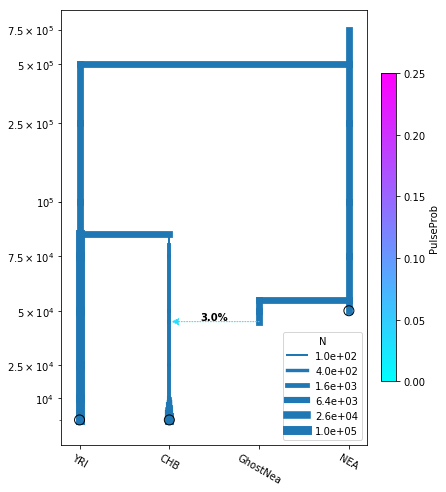

In [6]:
%matplotlib inline

yticks = [1e4, 2.5e4, 5e4, 7.5e4, 1e5, 2.5e5, 5e5, 7.5e5]

fig = momi.DemographyPlot(
    model, ["YRI", "CHB", "GhostNea", "NEA"],
    figsize=(6,8),
    major_yticks=yticks,
    linthreshy=1e5, pulse_color_bounds=(0,.25))

Note the user needs to specify the order of all populations (including
ghost populations) along the x-axis.

The argument `linthreshy` is useful for visualizing demographic events
at different scales. In our example, the split time of NEA is far above
the other events. Times below `linthreshy` are plotted on a linear
scale, while times above it are plotted on a log scale.



## Reading and simulating data 

In this section we demonstrate how to read in data from a VCF file.
We start by simulating a dataset so that we can read it in later. 

### Simulating data 

Use [DemographicModel.simulate_vcf](api.rst#momi.DemographicModel.simulate_vcf)
to simulate data (using [msprime](https://msprime.readthedocs.io/)) and save the resulting dataset
to a VCF file.

Below we simulate a dataset of diploid individuals,
with 20 "chromosomes" of length 50Kb, with a recombination
rate of 1.25e-8. 

In [7]:
recoms_per_gen = 1.25e-8
bases_per_locus = int(5e5)
n_loci = 20
ploidy = 2

# n_alleles per population (n_individuals = n_alleles / ploidy)
sampled_n_dict = {"NEA":2, "YRI":4, "CHB":4}

# create data directory if it doesn't exist
!mkdir -p tutorial_datasets/

# simulate 20 "chromosomes", saving each in a separate vcf file
for chrom in range(1, n_loci+1):
      model.simulate_vcf(
            f"tutorial_datasets/{chrom}",
            recoms_per_gen=recoms_per_gen,
            length=bases_per_locus,
            chrom_name=f"chr{chrom}",
            ploidy=ploidy,
            random_seed=1234+chrom,
            sampled_n_dict=sampled_n_dict,
            force=True)

We saved the datasets in `tutorial_datasets/$chrom.vcf.gz`. Accompanying tabix and bed files are also created.

In [8]:
!ls tutorial_datasets/

10.bed	       14.bed	      18.bed	     2.bed	   6.bed
10.vcf.gz      14.vcf.gz      18.vcf.gz      2.vcf.gz	   6.vcf.gz
10.vcf.gz.tbi  14.vcf.gz.tbi  18.vcf.gz.tbi  2.vcf.gz.tbi  6.vcf.gz.tbi
11.bed	       15.bed	      19.bed	     3.bed	   7.bed
11.vcf.gz      15.vcf.gz      19.vcf.gz      3.vcf.gz	   7.vcf.gz
11.vcf.gz.tbi  15.vcf.gz.tbi  19.vcf.gz.tbi  3.vcf.gz.tbi  7.vcf.gz.tbi
12.bed	       16.bed	      1.bed	     4.bed	   8.bed
12.vcf.gz      16.vcf.gz      1.vcf.gz	     4.vcf.gz	   8.vcf.gz
12.vcf.gz.tbi  16.vcf.gz.tbi  1.vcf.gz.tbi   4.vcf.gz.tbi  8.vcf.gz.tbi
13.bed	       17.bed	      20.bed	     5.bed	   9.bed
13.vcf.gz      17.vcf.gz      20.vcf.gz      5.vcf.gz	   9.vcf.gz
13.vcf.gz.tbi  17.vcf.gz.tbi  20.vcf.gz.tbi  5.vcf.gz.tbi  9.vcf.gz.tbi


### Read in data from vcf 

Now we read in the datasets we just simulated.

The first step is to create a mapping from individuals to populations.
We save this mapping to a text file whose first column
is for individuals and second column is for populations.

In [9]:
# a dict mapping samples to populations
ind2pop = {}
for pop, n in sampled_n_dict.items():
    for i in range(int(n / ploidy)):
        # in the vcf, samples are named like YRI_0, YRI_1, CHB_0, etc
        ind2pop["{}_{}".format(pop, i)] = pop

with open("tutorial_datasets/ind2pop.txt", "w") as f:
    for i, p in ind2pop.items():
        print(i, p, sep="\t", file=f)

!cat tutorial_datasets/ind2pop.txt

NEA_0	NEA
YRI_0	YRI
YRI_1	YRI
CHB_0	CHB
CHB_1	CHB


#### Compute allele counts

The next step is to compute the allele counts for each VCF separately.
To do this, use the shell command `python -m momi.read_vcf $VCF $IND2POP $OUTFILE --bed $BED`: 

In [10]:
%%sh
for chrom in `seq 1 20`;
do
    python -m momi.read_vcf \
           tutorial_datasets/$chrom.vcf.gz tutorial_datasets/ind2pop.txt \
           tutorial_datasets/$chrom.snpAlleleCounts.gz \
           --bed tutorial_datasets/$chrom.bed
done

The `--bed` flag specifies a BED accessible regions file. The BED file also determines
the length of the data in bases.

You should NOT use the same BED file across multiple VCF files, and should ensure your
BED files do not contain overlapping regions. Otherwise, regions will be double-counted when computing
the length of the data. You can use tabix to split a single BED file into multiple non-overlapping files.

By default ancestral alleles are read from the INFO AA field
(SNPs missing this field are skipped) but this behavior can be
changed by setting the flags `--no_aa` or `--outgroup`.

Use the `--help` flag to see more command line options,
and see also the documentation for [SnpAlleleCounts.read_vcf](api.rst#momi.SnpAlleleCounts.read_vcf),
which provides the same functionality within Python.

#### Extract combined SFS

Use `python -m momi.extract_sfs $OUTFILE $NBLOCKS $COUNTS...` from the command line to combine the SFS across multiple files, and split the SFS into a number of equally sized blocks for jackknifing and bootstrapping. 

In [11]:
%%sh
python -m momi.extract_sfs tutorial_datasets/sfs.gz 100 tutorial_datasets/*.snpAlleleCounts.gz

Use the `--help` flag to see the command line options,
and see also the documentation for [SnpAlleleCounts.concatenate](api.rst#momi.SnpAlleleCounts.concatenate)
and [SnpAlleleCounts.extract_sfs](api.rst#momi.SnpAlleleCounts.extract_sfs)
which provide the same functionality within Python. 

#### Read SFS into Python

Finally, read the SFS file into Python with [Sfs.load](api.rst#momi.Sfs.load): 

In [12]:
sfs = momi.Sfs.load("tutorial_datasets/sfs.gz")

## Inference 

In this section we will infer a demography for the data we simulated.
We will start by fitting a sub-demography on CHB and YRI, and then
iteratively build on this model, by adding the NEA population and also
additional parameters and events. 

### An initial model for YRI and CHB 

We will start by fitting a simplifed model without admixture.
Use `DemographicModel()` to initialize it as before:

In [13]:
no_pulse_model = momi.DemographicModel(
    N_e=1.2e4, gen_time=29, muts_per_gen=1.25e-8)

Note that `muts_per_gen` is optional, and can be omitted if unknown, but specifying it provides extra power to the model.

Use [DemographicModel.set_data](api.rst#momi.DemographicModel.set_data)
to add data to the model for inference:

In [14]:
no_pulse_model.set_data(sfs)

To add parameters to the model, use
[DemographicModel.add_size_param](api.rst#momi.DemographicModel.add_size_param),
[DemographicModel.add_time_param](api.rst#momi.DemographicModel.add_time_param),
[DemographicModel.add_growth_param](api.rst#momi.DemographicModel.add_growth_param),
and
[DemographicModel.add_pulse_param](api.rst#momi.DemographicModel.add_pulse_param).

Below we define parameters for the CHB size, the CHB growth rate,
and the CHB-YRI split time: 

In [15]:
# random initial value
no_pulse_model.add_size_param("n_chb") 
# initial value 0; user-specified lower,upper bounds
no_pulse_model.add_growth_param("g_chb", 0, lower=-1e-3, upper=1e-3)
# random initial value; user-specified lower bound
no_pulse_model.add_time_param("t_chb_yri", lower=1e4) 

Demographic events can be added similarly as before. 
Parameters are specified by name (string), 
while constants are specified as numbers (float).

In [16]:
no_pulse_model.add_leaf("CHB", N="n_chb", g="g_chb")
no_pulse_model.add_leaf("YRI", N=1e5)
no_pulse_model.set_size("CHB", t=1e4, g=0)
no_pulse_model.move_lineages("CHB", "YRI", t="t_chb_yri", N=1.2e4)

Use [DemographicModel.optimize](api.rst#momi.DemographicModel.optimize) to search for the MLE.
It is a thin wrapper around [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) and accepts similar arguments. 

In [17]:
no_pulse_model.optimize(method="TNC") 

            fun: 0.003542310828277693
            jac: array([-3.13076948e-05,  5.23632405e-02, -3.51395442e-09])
  kl_divergence: 0.003542310828277693
 log_likelihood: -30431.225365011265
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 70
            nit: 25
     parameters: ParamsDict({'n_chb': 29870.925066802884, 'g_chb': 0.0003777363527426479, 't_chb_yri': 115624.06976785387})
         status: 1
        success: True
              x: array([1.03046409e+01, 3.77736353e-04, 1.05624070e+05])

The default optimization method is `method="TNC"` (truncated Newton conjugate).
This is very accurate but can be slow for large models; for large models,
`method="L-BFGS-B"` is a good choice.

We can print the inferred parameter values with [DemographicModel.get_params](api.rst#momi.DemographicModel.get_params): 

In [18]:
no_pulse_model.get_params()

ParamsDict([('n_chb', 29870.925066802884),
            ('g_chb', 0.0003777363527426479),
            ('t_chb_yri', 115624.06976785387)])

and we can plot the inferred demography as before:

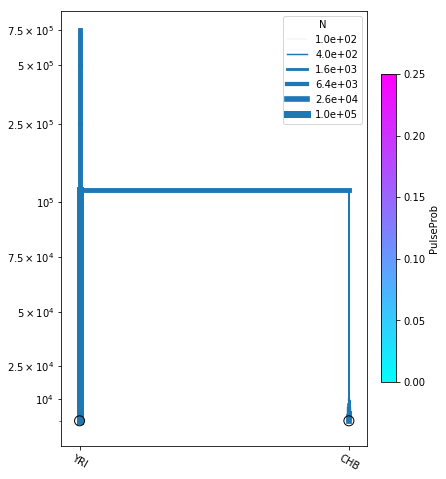

In [19]:
# plot the model
fig = momi.DemographyPlot(no_pulse_model, ["YRI", "CHB"],
                          figsize=(6,8), linthreshy=1e5,
                          major_yticks=yticks,
                          pulse_color_bounds=(0,.25))

### Adding NEA to the existing model 

Now we add in the NEA population, along with a parameter for its split time
`t_anc`. We use the keyword `lower_constraints` to require that `t_anc > t_chb_yri`. 

In [20]:
no_pulse_model.add_leaf("NEA", t=5e4)
no_pulse_model.add_time_param("t_anc", lower=5e4, lower_constraints=["t_chb_yri"])
no_pulse_model.move_lineages("YRI", "NEA", t="t_anc")

We search for the new MLE and plot the inferred demography: 

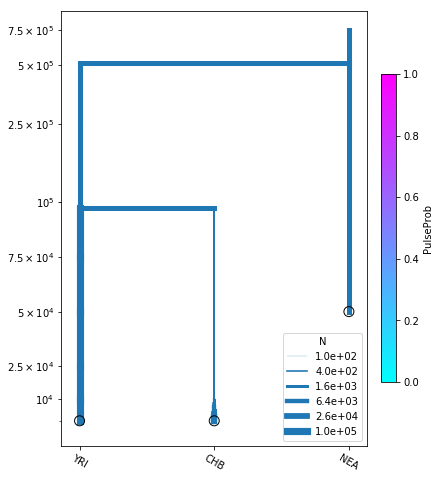

In [21]:
no_pulse_model.optimize()

fig = momi.DemographyPlot(
    no_pulse_model, ["YRI", "CHB", "NEA"],
    figsize=(6,8), linthreshy=1e5,
    major_yticks=yticks) 

### Build a new model adding NEA->CHB 

Now we create a new `DemographicModel`,
by copying the previous model and adding a NEA->CHB
migration arrow. 

In [22]:
add_pulse_model = no_pulse_model.copy()
add_pulse_model.add_pulse_param("p_pulse", upper=.25)
add_pulse_model.add_time_param(
    "t_pulse", upper_constraints=["t_chb_yri"])

add_pulse_model.move_lineages(
    "CHB", "GhostNea", t="t_pulse", p="p_pulse")

add_pulse_model.add_time_param(
    "t_ghost", lower=5e4,
    lower_constraints=["t_pulse"], upper_constraints=["t_anc"])
add_pulse_model.move_lineages(
    "GhostNea", "NEA", t="t_ghost")

It turns out this model has local optima, so we demonstrate how to
fit a few independent runs with different starting parameters.

Use [DemographicModel.set_params](api.rst#momi.DemographicModel.set_params)
to set new parameter values
to start the search from. If a parameter is not specified and
`randomize=True`, a new value will be randomly sampled for it.

In [23]:
results = []
n_runs = 3
for i in range(n_runs):
    print(f"Starting run {i+1} out of {n_runs}...")
    add_pulse_model.set_params(
        # parameters inherited from no_pulse_model are set to their previous values
        no_pulse_model.get_params(),
        # other parmaeters are set to random initial values
        randomize=True)

    results.append(add_pulse_model.optimize(options={"maxiter":200}))

# sort results according to log likelihood, pick the best one
best_result = sorted(results, key=lambda r: r.log_likelihood)[0]

add_pulse_model.set_params(best_result.parameters)
best_result

Starting run 1 out of 3...
Starting run 2 out of 3...
Starting run 3 out of 3...


            fun: 0.006023410093977509
            jac: array([-3.30591473e-06,  2.08703389e-02, -3.27482828e-11, -3.46359185e-11,
        3.89356928e-07, -2.33696129e-06,  1.94425825e-07])
  kl_divergence: 0.006023410093977509
 log_likelihood: -61262.30633302449
        message: 'Converged (|f_n-f_(n-1)| ~= 0)'
           nfev: 62
            nit: 13
     parameters: ParamsDict({'n_chb': 6610410.210113173, 'g_chb': 0.000945199071919152, 't_chb_yri': 98271.95240647999, 't_anc': 519659.0047170422, 'p_pulse': 0.016006434246168297, 't_pulse': 34330.646383018124, 't_ghost': 51783.135373811965})
         status: 1
        success: True
              x: array([ 1.57041563e+01,  9.45199072e-04,  8.82719524e+04,  4.21387052e+05,
       -4.11862858e+00, -6.21927133e-01, -5.56982976e+00])

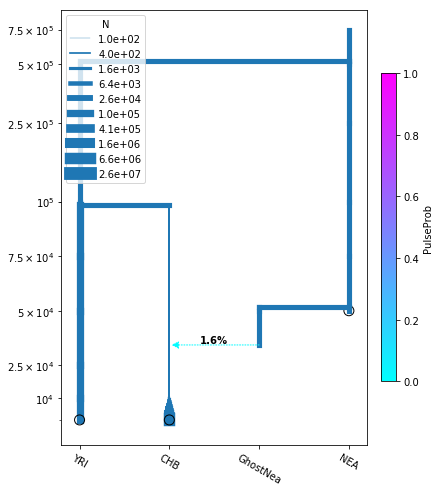

In [24]:
# plot the model
fig = momi.DemographyPlot(
    add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks)
# put legend in upper left corner
fig.draw_N_legend(loc="upper left") 

## Statistics of the SFS

Here we discuss how to compute statistics of the SFS,
for evaluating the goodness-of-fit of our models,
and for estimating the mutation rate.

### Goodness-of-fit

Use [SfsModelFitStats](api.rst#momi.SfsModelFitStats)
to see how well various
statistics of the SFS fit a model, via the block-jackknife.

Below we create an `SfsModelFitStats` to evaluate
the goodness-of-fit of the `no_pulse_model`.

In [25]:
no_pulse_fit_stats = momi.SfsModelFitStats(no_pulse_model)

One important statistic is the f4 or
"ABBA-BABA" statistic for detecting introgression
([Patterson et al 2012](api.rst#http://www.genetics.org/content/192/3/1065)).

In the absence of admixture f4(YRI, CHB, NEA, AncestralAllele)
should be 0, but for our dataset it will be negative due to the
NEA->CHB admixture.

Use [SfsModelFitStats.f4](api.rst#momi.SfsModelFitStats.f4)
to compute f4 stats. For the no-pulse model, we see that
`f4(YRI, CHB, NEA, AncestralAllele)` is indeed negative,
but unfortunately we don't have enough power to reject the model due to the small
amount of data.

In [26]:
print("Computing f4(YRI, CHB, NEA, AncestralAllele)")
f4 = no_pulse_fit_stats.f4("YRI", "CHB", "NEA", None)

print("Expected = {}".format(f4.expected))
print("Observed = {}".format(f4.observed))
print("SD = {}".format(f4.sd))
print("Z(Expected-Observed) = {}".format(f4.z_score))

Computing f4(YRI, CHB, NEA, AncestralAllele)
Expected = 3.469446951953614e-18
Observed = -0.0013236340985940571
SD = 0.0016783629249075718
Z(Expected-Observed) = -0.7886459352448778


The related `f2` and `f3` statistics are also available via
[SfsModelFitStats.f2](api.rst#momi.SfsModelFitStats.f2) and
[SfsModelFitStats.f3](api.rst#momi.SfsModelFitStats.f3).

Another method for evaluating model fit is
[SfsModelFitStats.all_pairs_ibs](api.rst#momi.SfsModelFitStats.all_pairs_ibs),
which computes the probability that 
two random alleles are the same, for every pair of populations: 

  Pop1 Pop2  Expected  Observed         Z
0  YRI  YRI  0.699009  0.705145  1.735736
1  NEA  NEA  0.731791  0.721525 -1.188249
2  CHB  YRI  0.694225  0.699135  1.109101
3  CHB  NEA  0.545198  0.544336 -0.170850
4  CHB  CHB  0.965871  0.965252 -0.139616
5  NEA  YRI  0.545198  0.544725 -0.106027

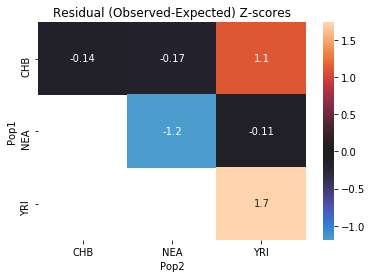

In [27]:
no_pulse_fit_stats.all_pairs_ibs()

Finally, the method
[SfsModelFitStats.tensor_prod](api.rst#momi.SfsModelFitStats)
can be used to
compute very general statistics of the
SFS (specifically, linear combinations of tensor-products of the SFS).
See the documentation for more details.

#### Limitations of `SfsModelFitStats`

Note the `SfsModelFitStats` class above has some limitations.
First, it computes goodness-of-fit for the SFS without any missing data;
all entries with missing samples are removed. For datasets
with many individuals and pervasive missingness, this can result
in most or all of the data being removed.

In such cases you can specify to use the SFS restricted
to a smaller number of samples; then all SNPs with at least
that many of non-missing individuals will be used.
For example, 

In [28]:
no_pulse_fit_stats = momi.SfsModelFitStats(
    no_pulse_model, {"YRI": 2, "CHB": 2, "NEA": 2})

will compute statistics for the SFS 
restricted to 2 samples per population.

The second limitation of `SfsModelFitStats` is that it
ignores the mutation rate -- it only fits the SFS normalized
to be a probability distribution.
However, see the next subsection on how to evaluate
the total number of mutations in the data. 

### Estimating mutation rate

To evaluate the total number of mutations in the data,
e.g. to fit the mutation rate, use the method
[DemographicModel.fit_within_pop_diversity](api.rst#momi.DemographicModel.fit_within_pop_diversity),
which computes the within-population nucleotide
diversity, i.e. the heterozygosity of a random
individual in that population assuming Hardy-Weinberg Equilibrium: 

In [29]:
no_pulse_model.fit_within_pop_diversity()

   Pop    EstMutRate   JackknifeSD  JackknifeZscore
0  CHB  1.278665e-08  1.631394e-09         0.175708
1  YRI  1.230290e-08  1.477173e-10        -1.334335
2  NEA  1.303958e-08  4.046466e-10         1.333468

This method returns a dataframe giving estimates for the mutation rate.
Note that there is an estimate for each population -- these estimates
are non-independent estimates for the same value, just computed
in different ways (by computing the expected to observed heterozygosity
for each population separately). These estimates
account for missingness in the data; it is fine to use it
on datasets with large amounts of missingness.

Since we initialized our model with `muts_per_gen=1.25e-8`,
the method also returns a Z-value for the residuals of the estimated
mutation rates.

## Bootstrap confidence intervals 

Use [Sfs.resample](api.rst#momi.Sfs.resample) to create bootstrap
datasets by resampling blocks of the SFS.

To generate confidence intervals, we can refit the model
on the bootstrap datasets and examine the quantiles of the re-inferred
parameters.
Below we do this for a very small number of bootstraps and a simplified
fitting procedure. In practice you would want to generate hundreds of bootstraps on a cluster computer. 

In [30]:
n_bootstraps = 5
# make copies of the original models to avoid changing them
no_pulse_copy = no_pulse_model.copy()
add_pulse_copy = add_pulse_model.copy()

bootstrap_results = []
for i in range(n_bootstraps):
    print(f"Fitting {i+1}-th bootstrap out of {n_bootstraps}")

    # resample the data
    resampled_sfs = sfs.resample()
    # tell models to use the new dataset
    no_pulse_copy.set_data(resampled_sfs)
    add_pulse_copy.set_data(resampled_sfs)

    # choose new random parameters for submodel, optimize
    no_pulse_copy.set_params(randomize=True)
    no_pulse_copy.optimize()
    # initialize parameters from submodel, randomizing the new parameters
    add_pulse_copy.set_params(no_pulse_copy.get_params(),
                              randomize=True)
    add_pulse_copy.optimize()

    bootstrap_results.append(add_pulse_copy.get_params())

Fitting 1-th bootstrap out of 5
Fitting 2-th bootstrap out of 5
Fitting 3-th bootstrap out of 5
Fitting 4-th bootstrap out of 5
Fitting 5-th bootstrap out of 5


We can visualize the bootstrap results by overlaying them onto a single plot.

/home/jack/.local/share/virtualenvs/momi2-gAXri9wX/lib/python3.6/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


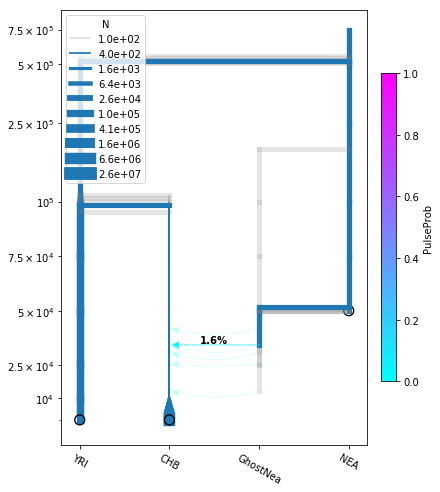

In [31]:
# make canvas, but delay plotting the demography (draw=False)
fig = momi.DemographyPlot(
    add_pulse_model, ["YRI", "CHB", "GhostNea", "NEA"],
    linthreshy=1e5, figsize=(6,8),
    major_yticks=yticks,
    draw=False)

# plot bootstraps onto the canvas in transparency
for params in bootstrap_results:
    fig.add_bootstrap(
        params,
        # alpha=0: totally transparent. alpha=1: totally opaque
        alpha=1/n_bootstraps)

# now draw the inferred demography on top of the bootstraps
fig.draw()
fig.draw_N_legend(loc="upper left") 

## Other features

### Stochastic gradient descent 

For large models, it can be useful to perform stochastic optimization:
instead of computing the full likelihood at every step,
we use a random subset of SNPs at each step to estimate
the likelihood gradient. This is especially useful for
rapidly searching for a reasonable starting point, from which
full optimization can be performed.

[DemographicModel.stochastic_optimize](api.rst#momi.DemographicModel.stochastic_optimize)
implements stochastic optimization with the [ADAM](https://arxiv.org/pdf/1412.6980.pdf) algorithm.
Setting `svrg=n` makes the optimizer use the full likelihood
every n steps which can lead to better convergence (see
[SVRG](https://papers.nips.cc/paper/4937-accelerating-stochastic-gradient-descent-using-predictive-variance-reduction.pdf)).

The cell below performs 10 steps of stochastic optimization,
using 1000 random SNPs per step, and computing the full likelihood
every 3 iterations. 

In [32]:
add_pulse_copy.stochastic_optimize(
    snps_per_minibatch=1000, num_iters=10, svrg_epoch=3)

     fun: 3.5745723758459165
     jac: array([ 9.38288753e-05, -9.68187680e-02,  2.51931144e-07, -1.13796422e-07,
        1.53560248e-02, -8.98963575e-05, -2.18461061e-08])
 message: 'Maximum number of iterations reached'
     nit: 9
 success: False
       x: array([ 1.28921714e+01, -1.00000000e-03,  8.51251936e+04,  4.58027273e+05,
       -4.44016245e+00,  1.56931356e-01, -1.13786610e+01])